# Use of estimated correlation models in regional seismic risk simulations

## Case study in the San Francisco Bay Area

This notebook shows how to apply the proposed correlation models in a regional seismic risk simulation workflow. 
Please consult the manuscript for further information on the underlying data sources etc.

We also provide an OpenQuake [1] compatible version in following repo: [Link to GitHub](https://github.com/bodlukas/ground-motion-simulation-shakemap)

[1] Silva, V., Crowley, H., Pagani, M. et al. Development of the OpenQuake engine, the Global Earthquake Model's open-source software for seismic risk assessment. Nat Hazards 72, 1409-1427 (2014).

In [2]:
import numpy as np
import pandas as pd
import os

### Import site and rupture data

We start with importing site data (at which we would like to simulate spatially correlated ground-motion fields), as well as rupture information (e.g., epicenter longitude and latitude).

In [4]:
path_data = os.path.join(os.getcwd() + os.sep + 'data' + os.sep 
                         + 'case_study' + os.sep)
# Load site-specific input data
dfsite = pd.read_csv(path_data + 'site_im_sa1_HaywardM625_UCERF2.csv')
# Load rupture data
dfrup = pd.read_csv(path_data + 'rup_HaywardM625_UCERF2.csv')

As seen below the site information already contains the logarithmic mean im $\mu_{\ln im}$ in g, as well as the standard deviations $\phi$ and $\tau$ of the within-event and between-event residuals. Those quantities are provided by a GMM (see manuscript). Apart from that we also have the latitude and longitude of each station, the corresponding soil conditions (via $v_{s,30}$ in m/s) and the subregion to which the site belongs to. Note that this case study focuses on elastic, 5%-damped spectral acceleration at a period of one second.

In [5]:
dfsite

,Latitude,Longitude,Vs30,subregion,medianim,total_std_dev,within_ev_std_dev,between_ev_std_dev
0,37.793125,-122.450625,423.91296,3,0.094237,0.695186,0.604420,0.343453
1,37.793125,-122.449792,336.55225,3,0.110520,0.686862,0.598274,0.337414
2,37.793125,-122.448958,335.83463,3,0.111135,0.686692,0.598148,0.337290
3,37.793125,-122.448125,733.40000,3,0.059507,0.702304,0.609685,0.348590
4,37.793125,-122.447292,733.40000,3,0.059722,0.702303,0.609684,0.348589
...,...,...,...,...,...,...,...,...
12425,37.758125,-122.160625,741.49780,2,0.125166,0.702095,0.609530,0.348440
12426,37.758125,-122.159792,741.44617,2,0.124737,0.702097,0.609531,0.348441
12427,37.758125,-122.158958,741.38380,2,0.124304,0.702098,0.609532,0.348442
12428,37.758125,-122.158125,741.31080,2,0.123870,0.702099,0.609533,0.348443


### Compute epicentral azimuth

Here we will compute the epicentral distance in km and epicentral azimuth in radians for each site. These polar coordinates are used in the corresponding model implementations as will be seen below.

In [6]:
from pyproj import Geod
def LongLatToPolar(Xst, Xeq):
    geod = Geod(ellps='WGS84')
    r = geod.inv(lons1 = Xeq[:, 0], lats1 = Xeq[:, 1], 
        lons2 = Xst[:, 0], lats2 = Xst[:, 1])
    repi = r[2]/1000
    az = r[0]*np.pi/180
    az[az<0] += 2*np.pi
    Xp = np.vstack([repi, az]).T
    return Xp

# Extract Long / Lat for sites and rupture epicenter
Xst = dfsite[['Longitude', 'Latitude']].values
Xeq = np.zeros_like(Xst)
Xeq[:,0] = dfrup.hypo_longitude.values
Xeq[:,1] = dfrup.hypo_latitude.values

# Transform Long / Lat to polar coordinates
Xp = LongLatToPolar(Xst, Xeq)
# Store as separate attributes in dataframe
dfsite['epicenter_dist'] = Xp[:,0]
dfsite['epicenter_azimuth'] = Xp[:,1]

### Import models and estimated parameters

Here we import the numpy implementations of the models $\mathrm{M}\in\{\mathrm{E},\mathrm{EA},\mathrm{EAS}\}$, as well as the parameter sets $\boldsymbol{\psi}_{\mathrm{M},r}$ sampled from the posterior distribution $p(\boldsymbol{\psi}_{\mathrm{M}}|\mathcal{D}_{tot})$ using MCMC. Each row corresponds to one sample $r=1,\ldots,4000$.

In [7]:
# Load models
from models_numpy import rhoE, rhoEA, rhoEAS
# Load posterior parameter samples for models
path_results = os.path.join(os.getcwd() + os.sep + 'results' + os.sep 
                            + 'PosteriorParameters' + os.sep)
models = ['E', 'EA', 'EAS']
dfparam = [pd.read_csv(path_results + 'PostParam_Pooled_T100_' + m + '.csv') for m in models]
i = 2
print('Example for model ' + models[i])
dfparam[i]

Example for model EAS


,LE,gammaE,LA,LS,w
0,30.268263,0.408575,20.801558,223.43585,0.669609
1,33.672764,0.397568,17.120098,170.94627,0.671312
2,30.728834,0.391851,18.938839,228.33913,0.670856
3,27.255333,0.436261,20.851435,172.33385,0.700243
4,26.872337,0.425766,21.752647,163.04816,0.684338
...,...,...,...,...,...
3995,28.459340,0.389887,19.919085,173.01701,0.745342
3996,30.105550,0.383317,19.840628,163.16116,0.726879
3997,29.550129,0.399115,21.767162,173.37833,0.751819
3998,32.199210,0.411692,19.769280,171.74321,0.750987


## Simulate ground-motion fields

Two methods have been compared in the manuscript:
- Sample from the posterior predictive via marginalizing over the posterior parameter distribution and thus accounting for the uncertainty in the estimated correlation model parameters. 
- Sample conditional on the posterior mean of the parameters, which is computationally much more efficient but neglects the uncertainty in the estimated correlation model parameters.

Below we define a function that computes the correlation matrix for a specific set of parameters depending on the chosen model. For this illustration we focus on model EAS and we will use 500 sites from the second subregion. Thus the results won't be fully identical with the figures presented in the manuscript.

In [8]:
def GetCorrelationMatrix(X, model, psi):
    if model == 'E': K = rhoE(X, psi.LE, psi.gammaE)
    elif model == 'EA': K = rhoEA(X, psi.LE, psi.gammaE, psi.LA)
    elif model == 'EAS': K = rhoEAS(X, psi.LE, psi.gammaE, 
                                    psi.LA, psi.LS, psi.w)
    return K

model = 'EAS'
subregion = 2
# Masked site information
dfmask = dfsite[dfsite.subregion==subregion].iloc[:500,:].copy()
# Extract the relevant site information in input matrix X
X = dfmask[['epicenter_dist', 'epicenter_azimuth', 'Vs30']].values
nsites = X.shape[0]

# Specify seed
seed = 91
rng = np.random.default_rng(seed)

# Specify number of simulated maps
numsim = 20000

### Using mean posterior parameters

As discussed in the manuscript we found only minor differences between both approaches for this case study. Thus we will first focus on the more computationally efficient second option.

The matrix `sim_im_meanparam` stores the simulation results. Each row corresponds to one spatially correlated realization of $Sa(1s)$ at the considered 500 sites in subregion 2. This can then be used for regional risk assessment, for example as an input to building fragility / vulnerability functions. 

In [9]:
# 1) Compute the posterior mean parameters from MCMC samples
idx = np.arange(3)[np.isin(models,model)][0]
mean_params = dfparam[idx].mean()

# 2) Compute entries of correlation matrix (shape nsites x nsites)
CorrMatrix = GetCorrelationMatrix(X, model, mean_params)

# 3) Simulate correlated within-event residuals (shape numsim x nsites)
sim_deltaW = (rng.multivariate_normal(np.zeros(nsites), CorrMatrix, numsim) * 
                dfmask.within_ev_std_dev.values[None,:])

# 4) Simulate one between-event residual per simulation (shape numsim x 1)
sim_deltaB = rng.normal(0,1,numsim)[:,None] * dfmask.between_ev_std_dev.values[None,:]

# 5) Add residuals and logarithmic mean im to get Sa(1s) in units of g (shape numsim x nsites)
sim_im_meanparam = np.exp( np.log(dfmask.medianim.values[None,:] )  
                          + sim_deltaW + sim_deltaB)

### Using posterior predictive

Above we used the posterior mean parameters to compute one covariance matrix which we used to draw all simulated maps from the same multivariate normal distribution. When we want to use the posterior predictive, we marginalize over the posterior parameter distribution. Each MCMC sample from the posterior parameter distribution yields a different covariance matrix. Thus the steps 2 and 3 in the workflow below differ from above.

In [10]:
# 1) Compute the posterior mean parameters from MCMC samples
idx = np.arange(3)[np.isin(models,model)][0]
mean_params = dfparam[idx].mean()

# 2) and 3) Simulate correlated within-event residuals 
sim_deltaW = []
for i, param in dfparam[idx].iterrows(): # iterate over each posterior MCMC sample
    CorrMatrix = GetCorrelationMatrix(X, model, param) # build correlation matrix
    # 5 simulations for each of the 4000 MCMC samples yield 20000 simulations
    sim_deltaW.append(rng.multivariate_normal(np.zeros(nsites), CorrMatrix, 5) * 
                dfmask.within_ev_std_dev.values[None,:])
sim_deltaW = np.vstack(sim_deltaW) # (shape numsim x nsites)

# 4) Simulate one between-event residual per simulation (shape numsim x 1)
sim_deltaB = rng.normal(0,1,numsim)[:,None] * dfmask.between_ev_std_dev.values[None,:]

# 5) Add residuals and logarithmic mean im to get Sa(1s) in units of g (shape numsim x nsites)
sim_im_postpred = np.exp( np.log(dfmask.medianim.values[None,:] )  
                          + sim_deltaW + sim_deltaB)

## Count and plot joint exceedances of IM threshold

To enable a comparison across different IMs we compute the proportion of sites at which a certain site-specific threshold was jointly exceeded in the specified rupture scenario.

As stated in Section 2 of the manuscript, the GMM provides for each site $i$, the mean of the logarithmic $im$, and the standard deviations $\phi$ and $\tau$ of the between- and within-event residuals. Based on that information, we compute for each site the $im$ value which has a 10% probability of being exceeded in the specified scenario. The exceedance probability of $sa$ follows from
$$
P(Sa(T) > sa) = 1 - \Phi\left(\frac{sa - \mu_{lnIM}}{\sqrt{\phi^2 + \tau^2}}\right)~,
$$
and the site-specific thresholds are obtained by solving the above equation for the desired exceedance probability (here 10%).

In [11]:
from scipy.stats import norm
def get_thresholds(dfsites, poe=0.1):
    mu_logIM = np.log(dfsites.medianim.values)
    sigma_logIM = np.sqrt(dfsites.between_ev_std_dev.values**2 +
                            dfsites.within_ev_std_dev.values**2)
    # norm.ppf(1-poe, mu_logIM, sigma_logIM)
    return np.exp(norm.ppf(1-poe, mu_logIM, sigma_logIM))

In [12]:
# threshold_im = 0.75 # Uncomment for fixed threshold in g!
threshold_im = get_thresholds(dfmask)
prop_ex_meanparam = np.sum(sim_im_meanparam > threshold_im, axis=1)/nsites
prop_ex_postpred = np.sum(sim_im_postpred > threshold_im, axis=1)/nsites

C:\Users\bodlukas\AppData\Local\Temp\ipykernel_6476\2573532767.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn'])


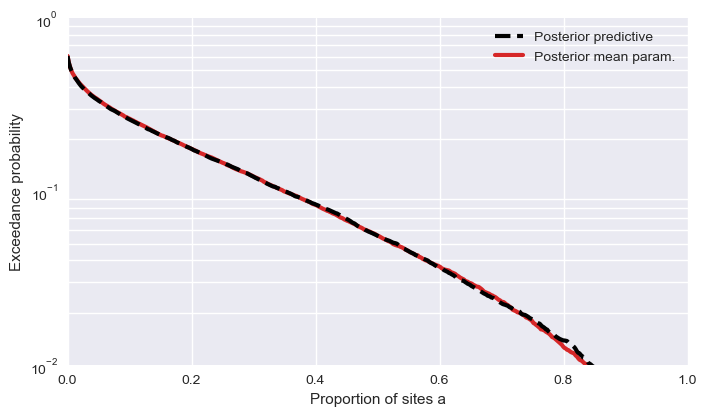

In [13]:
def ecdf(sim, x):
    F = []
    for i in x:
        F.append(1/len(sim) * np.sum(sim<=i))
    return np.stack(F)
xaxis = np.linspace(0, 1, nsites)

import matplotlib.pyplot as plt
plt.style.use(['seaborn'])
fig, ax = plt.subplots(figsize=(8,4.5))
ax.plot(xaxis, 1-ecdf(prop_ex_postpred, xaxis), lw=3, color='black', 
        ls='--', zorder=2, label='Posterior predictive')
ax.plot(xaxis, 1-ecdf(prop_ex_meanparam, xaxis), lw=3, color='tab:red', 
        ls='-', zorder=1, label='Posterior mean param.')
ax.set_yscale('log')
ax.set_ylim([0.01,1])
ax.set_xlim([0,1])
ax.grid(axis='y',which='both')
ax.set_ylabel('Exceedance probability')
ax.set_xlabel('Proportion of sites a')
ax.legend()